In [1]:
!pip install -r /content/drive/MyDrive/ColabNotebooks/requirements.txt


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.4/44.4 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.6/52.6 kB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 259.8/259.8 kB 13.0 MB/s eta 0:00:00


In [2]:
import pandas as pd
df_traffic_announcment = pd.read_csv(
"/content/drive/MyDrive/ColabNotebooks/Datasets/traffic-announcment.csv")

# Tarih sütununu datetime formatına çevir
df_traffic_announcment['ANNOUNCEMENT_STARTING_DATETIME'] = pd.to_datetime(df_traffic_announcment['ANNOUNCEMENT_STARTING_DATETIME'])

# 2024 yılına ait olanları filtrele
df_2024 = df_traffic_announcment[df_traffic_announcment['ANNOUNCEMENT_STARTING_DATETIME'].dt.year == 2024]
df_2024.to_csv("/content/drive/MyDrive/ColabNotebooks/Datasets/traffic-announcment-2024.csv", index=False)



In [3]:
print(df_2024['ANNOUNCEMENT_TYPE_DESC'].unique())

df_2024_accident = df_2024[df_2024['ANNOUNCEMENT_TYPE_DESC'] == 'Kaza Bildirimi']
df_2024_accident.to_csv("/content/drive/MyDrive/ColabNotebooks/Datasets/traffic-announcment-2024-accident.csv", index=False) #11426 data

['Kaza Bildirimi' 'Bakım-Onarım Çalışması' 'Çevre Düzenlemesi'
 'Alt Yapı Çalışması' 'İmalat Çalışması' 'Yol Yapım Çalışması']


In [4]:
import pandas as pd
import matplotlib.pyplot as plt

# Veri setini oku
df = pd.read_csv("/content/drive/MyDrive/ColabNotebooks/Datasets/traffic-announcment-2024-accident.csv", parse_dates=['ANNOUNCEMENT_STARTING_DATETIME'])

# Saat bilgisini çıkar
df['HOUR'] = df['ANNOUNCEMENT_STARTING_DATETIME'].dt.hour

# Saat bazlı kaza sayısı
hourly_counts = df['HOUR'].value_counts().sort_index()

# Saatleri 06-07, 07-08... şeklinde gruplamak için:
hourly_range = pd.cut(df['HOUR'], bins=range(0, 25), right=False)
range_counts = hourly_range.value_counts().sort_index()


In [8]:
import pandas as pd
import os

root_path = "/content/drive/MyDrive/ColabNotebooks/Datasets"

# Ay isimleri (sıralı)
months = [
    "january", "february", "march", "april", "may", "june",
    "july", "august", "september", "october", "november", "december"
]

# Dosya yollarını otomatik oluştur
monthly_files = [
    os.path.join(root_path, f"traffic-density-2024-{month}.csv") for month in months
    # Eğer henüz olmayan dosyalar varsa:
    # if os.path.exists(os.path.join(root_path, f"traffic-density-2024-{month}.csv"))
]

all_months = []

# Her dosyayı sırayla işle
for file_path in monthly_files:
    df = pd.read_csv(file_path, parse_dates=["DATE_TIME"])

    # Yalnızca 2024 yılı verisi (kontrol amaçlı)
    df = df[df["DATE_TIME"].dt.year == 2024]

    # Tarih ve saat sütunlarını çıkar
    df["DATE"] = df["DATE_TIME"].dt.date
    df["HOUR"] = df["DATE_TIME"].dt.hour

    # Gün + saat bazlı ortalama veriler
    agg_df = df.groupby(["DATE", "HOUR"]).agg({
        "MINIMUM_SPEED": "mean",
        "MAXIMUM_SPEED": "mean",
        "AVERAGE_SPEED": "mean",
        "NUMBER_OF_VEHICLES": "mean"
    }).reset_index()

    # Sütun adlarını güncelle
    agg_df.columns = ["DATE", "HOUR", "AVG_MIN_SPEED", "AVG_MAX_SPEED", "AVG_AVG_SPEED", "AVG_VEHICLE_COUNT"]

    # Listeye ekle
    all_months.append(agg_df)

# Hepsini birleştir
final_df = pd.concat(all_months, ignore_index=True)

# İsteğe bağlı: tarihi sıraya koy
final_df = final_df.sort_values(by=["DATE", "HOUR"]).reset_index(drop=True)

# CSV olarak kaydet
final_df.to_csv("/content/drive/MyDrive/ColabNotebooks/Datasets/traffic-density-2024-all.csv", index=False)

print("Birleştirilmiş veri başarıyla kaydedildi.")



Birleştirilmiş veri başarıyla kaydedildi.


In [10]:
import pandas as pd

# 1. Kaza verisini oku
accidents = pd.read_csv("/content/drive/MyDrive/ColabNotebooks/Datasets/traffic-announcment-2024-accident.csv", parse_dates=["ANNOUNCEMENT_STARTING_DATETIME"])

# 2. Tarih ve saat çıkar (saat aralığına göre eşleşmesi için)
accidents['DATE'] = accidents['ANNOUNCEMENT_STARTING_DATETIME'].dt.date
accidents['HOUR'] = accidents['ANNOUNCEMENT_STARTING_DATETIME'].dt.hour

# 3. Saatlik kaza sayısını gruplandır
hourly_accidents = accidents.groupby(['DATE', 'HOUR']).size().reset_index(name='ACCIDENT_COUNT')

# 4. Trafik + weather birleşik verisini yükle
traffic_weather = pd.read_csv("/content/drive/MyDrive/ColabNotebooks/Datasets/traffic-density-2024-all.csv")
traffic_weather['DATE'] = pd.to_datetime(traffic_weather['DATE']).dt.date
traffic_weather['HOUR'] = traffic_weather['HOUR'].astype(int)

# 5. Birleştir (left join ile)
final_df = pd.merge(traffic_weather, hourly_accidents, on=['DATE', 'HOUR'], how='left')

# 6. Kazası olmayan saatler için 0 ata
final_df['ACCIDENT_COUNT'] = final_df['ACCIDENT_COUNT'].fillna(0).astype(int)

# 7. Sonuçları kontrol et
print(final_df.head())

# 8. Kaydetmek istersen:
final_df.to_csv("/content/drive/MyDrive/ColabNotebooks/Datasets/traffic_density_with_weather_and_accidents.csv", index=False)


         DATE  HOUR  AVG_MIN_SPEED  AVG_MAX_SPEED  AVG_AVG_SPEED  \
0  2024-01-01     0      29.183849     101.814003      61.064863   
1  2024-01-01     1      31.073307     100.606727      61.526520   
2  2024-01-01     2      32.170806     100.437037      62.501525   
3  2024-01-01     3      33.020633      97.719395      62.421366   
4  2024-01-01     4      32.140064      99.179172      62.444748   

   AVG_VEHICLE_COUNT  ACCIDENT_COUNT  
0          43.638746               2  
1          38.678741               1  
2          28.713290               3  
3          24.672627               2  
4          24.065939               0  


In [2]:
import pandas as pd

df = pd.read_csv("/content/drive/MyDrive/ColabNotebooks/Datasets/traffic_density_with_weather_and_accidents.csv")
df['ACCIDENT_CLASS'] = df['ACCIDENT_COUNT'].apply(lambda x:
    0 if x in [0] else
    1
)

df.to_csv("/content/drive/MyDrive/ColabNotebooks/Datasets/traffic_density_with_weather_and_accidents.csv", index=False)




In [20]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, accuracy_score


# 🔢 Özellikler ve hedef değişken
features = [
    "HOUR", "AVG_MIN_SPEED", "AVG_MAX_SPEED", "AVG_AVG_SPEED", "AVG_VEHICLE_COUNT"]
target = "ACCIDENT_CLASS"

X = df[features]
y = df[target]

# 🔄 Ölçekleme (GradientBoosting için şart değil ama dengeler)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 🎓 Eğitim ve test setine ayır
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# 🚀 Modeli oluştur ve eğit
model = GradientBoostingClassifier(random_state=42)
model.fit(X_train, y_train)

# 🔍 Tahmin ve değerlendirme
y_pred = model.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.7776397515527951

Classification Report:
               precision    recall  f1-score   support

           0       0.75      0.57      0.65       574
           1       0.79      0.89      0.84      1036

    accuracy                           0.78      1610
   macro avg       0.77      0.73      0.74      1610
weighted avg       0.77      0.78      0.77      1610



    HOUR  AVG_ACCIDENT_COUNT
0      0            0.824561
1      1            0.482353
2      2            0.275148
3      3            0.210059
4      4            0.157738
5      5            0.176119
6      6            0.465672
7      7            0.982143
8      8            1.768546
9      9            1.752212
10    10            1.722714
11    11            1.731563
12    12            1.740413
13    13            1.790560
14    14            2.008850
15    15            2.378698
16    16            2.355030
17    17            1.732733
18    18            1.773414
19    19            1.577039
20    20            1.407295
21    21            1.516820
22    22            1.371166
23    23            1.116923


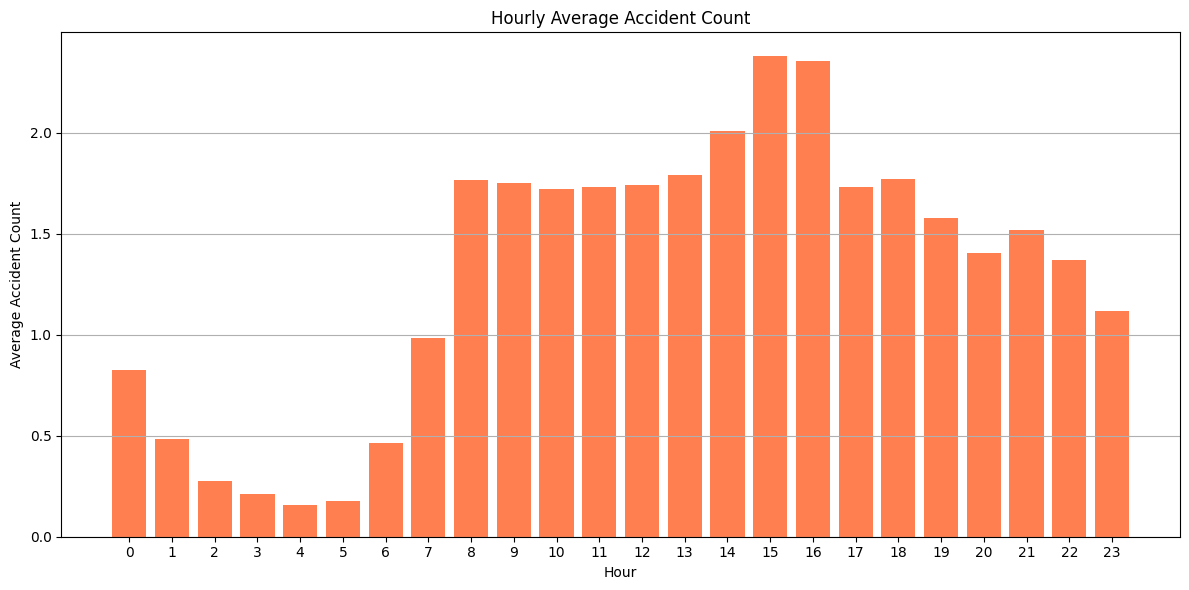

In [27]:
import matplotlib.pyplot as plt

# Saatlik kaza sayısını hesapla
hourly_accident_count = df.groupby('HOUR')['ACCIDENT_COUNT'].mean().reset_index()
hourly_accident_count.columns = ['HOUR', 'AVG_ACCIDENT_COUNT']

# Sonuçları yazdır
print(hourly_accident_count)

# Saatlik kaza sayısını görselleştir
plt.figure(figsize=(12, 6))
plt.bar(hourly_accident_count['HOUR'], hourly_accident_count['AVG_ACCIDENT_COUNT'], color='coral')
plt.xticks(range(24))
plt.xlabel("Hour")
plt.ylabel("Average Accident Count")
plt.title("Hourly Average Accident Count")
plt.grid(axis='y')
plt.tight_layout()
plt.show()


    HOUR  AVG_TRAFFIC_DENSITY
0      0             1.160310
1      1             0.767862
2      2             0.540355
3      3             0.465451
4      4             0.540635
5      5             1.090896
6      6             2.324267
7      7             2.757120
8      8             2.493395
9      9             2.436355
10    10             2.421199
11    11             2.403298
12    12             2.458711
13    13             2.461174
14    14             2.498904
15    15             2.546585
16    16             2.552583
17    17             2.742720
18    18             2.751933
19    19             2.400476
20    20             1.873753
21    21             1.695492
22    22             1.556249
23    23             1.450735


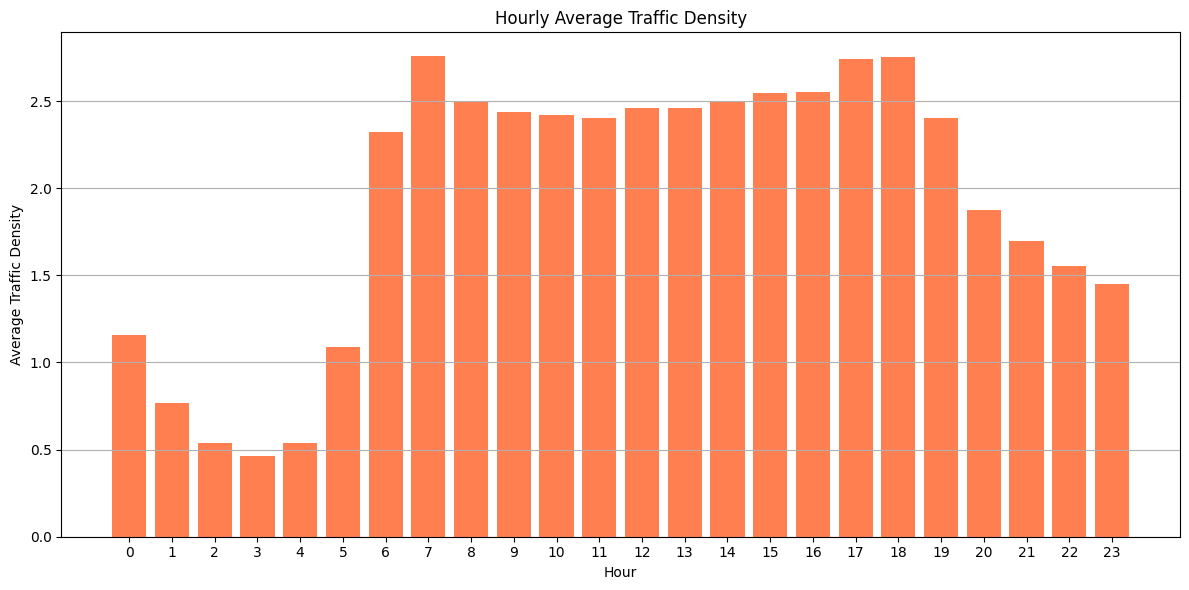

In [28]:
import matplotlib.pyplot as plt

# Trafik yoğunluğunu hesapla (AVG_VEHICLE_COUNT / AVG_AVG_SPEED)
df['TRAFFIC_DENSITY'] = df['AVG_VEHICLE_COUNT'] / df['AVG_AVG_SPEED']

# Saatlik trafik yoğunluğunu hesapla
hourly_traffic_density = df.groupby('HOUR')['TRAFFIC_DENSITY'].mean().reset_index()
hourly_traffic_density.columns = ['HOUR', 'AVG_TRAFFIC_DENSITY']

# Sonuçları yazdır
print(hourly_traffic_density)

# Saatlik trafik yoğunluğunu görselleştir
plt.figure(figsize=(12, 6))
plt.bar(hourly_traffic_density['HOUR'], hourly_traffic_density['AVG_TRAFFIC_DENSITY'], color='coral')
plt.xticks(range(24))
plt.xlabel("Hour")
plt.ylabel("Average Traffic Density")
plt.title("Hourly Average Traffic Density")
plt.grid(axis='y')
plt.tight_layout()
plt.show()


In [3]:
print(df['ACCIDENT_CLASS'].value_counts())


ACCIDENT_CLASS
1    5056
0    2993
Name: count, dtype: int64


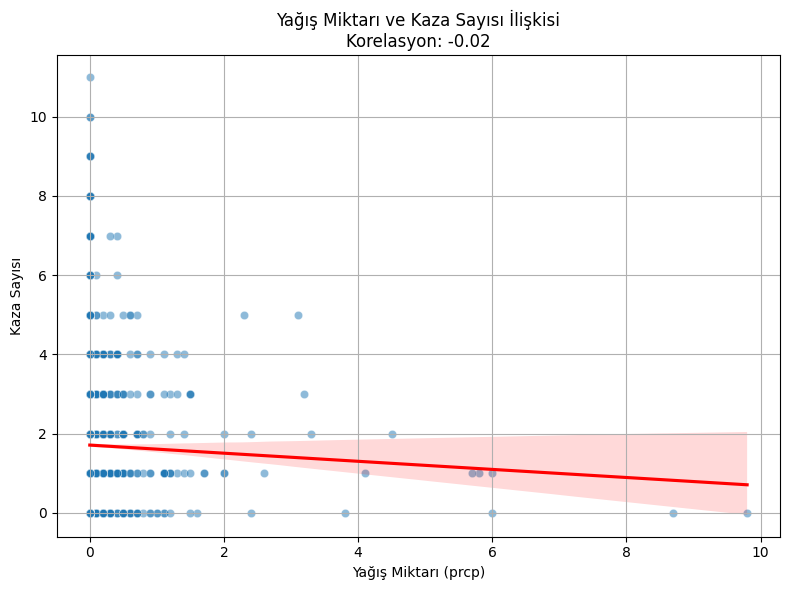

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Korelasyon değeri
correlation = df[['prcp', 'ACCIDENT_COUNT']].corr().iloc[0, 1]

# Grafik
plt.figure(figsize=(8, 6))
sns.scatterplot(x='prcp', y='ACCIDENT_COUNT', data=df, alpha=0.5)
sns.regplot(x='prcp', y='ACCIDENT_COUNT', data=df, scatter=False, color='red')
plt.title(f"Yağış Miktarı ve Kaza Sayısı İlişkisi\nKorelasyon: {correlation:.2f}")
plt.xlabel("Yağış Miktarı (prcp)")
plt.ylabel("Kaza Sayısı")
plt.grid(True)
plt.tight_layout()
plt.show()

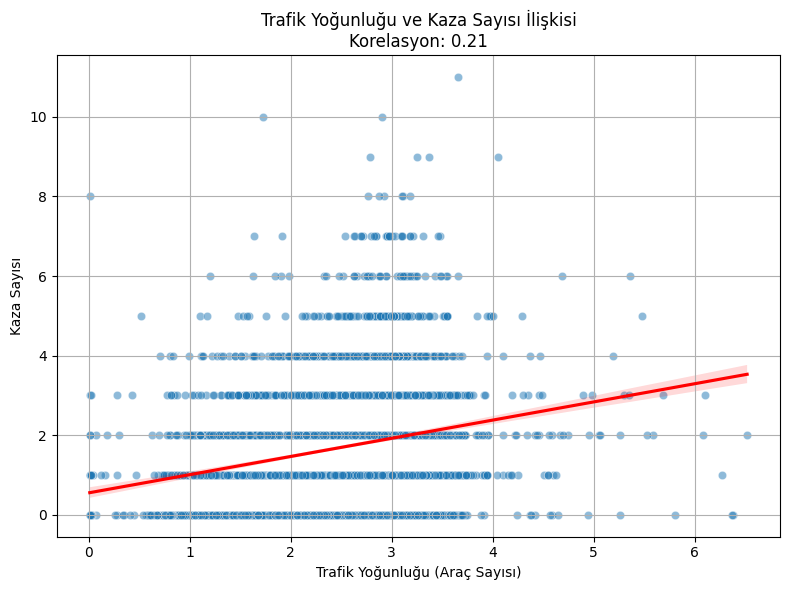

In [36]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns




# Alternatif: Yoğunluk oranı (isteğe bağlı)
df['TRAFFIC_DENSITY'] = df['AVG_VEHICLE_COUNT'] / df['AVG_AVG_SPEED']

# Korelasyon hesapla
correlation = df[['AVG_AVG_SPEED', 'ACCIDENT_COUNT']].corr().iloc[0, 1]

# Grafik çizimi
plt.figure(figsize=(8, 6))
sns.scatterplot(x='TRAFFIC_DENSITY', y='ACCIDENT_COUNT', data=df, alpha=0.5)
sns.regplot(x='TRAFFIC_DENSITY', y='ACCIDENT_COUNT', data=df, scatter=False, color='red')
plt.title(f"Trafik Yoğunluğu ve Kaza Sayısı İlişkisi\nKorelasyon: {correlation:.2f}")
plt.xlabel("Trafik Yoğunluğu (Araç Sayısı)")
plt.ylabel("Kaza Sayısı")
plt.grid(True)
plt.tight_layout()
plt.show()
